In [1]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
from astroquery.vizier import Vizier
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii

## Selecting SDSS/BOSS cross-matched

In [2]:
sdss = pd.read_csv('/home/iago.dias/SDSS-BOSS.csv')

In [3]:
sdss = sdss[sdss['f_zsp']<40]

In [4]:
sdss = sdss[['RA_ICRS','DE_ICRS','zsp']]
sdss.columns = ['ra','dec','z']

In [5]:
sdss['survey']='SDSS/BOSS'

In [6]:
sdss = sdss[(sdss['ra']>35) & (sdss['ra']<37.5) & (sdss['dec']<-3.5)& (sdss['dec']>-5.7)] 

In [7]:
sdss

,ra,dec,z,survey
229,37.255031,-5.688772,0.95767,SDSS/BOSS
237,37.290464,-5.670331,0.33875,SDSS/BOSS
238,37.437218,-5.675375,0.48237,SDSS/BOSS
239,37.413628,-5.640567,0.08701,SDSS/BOSS
240,37.390754,-5.624758,0.98790,SDSS/BOSS
...,...,...,...,...
1712,35.285733,-3.539826,0.57483,SDSS/BOSS
1713,35.278646,-3.524045,0.55166,SDSS/BOSS
1715,35.510182,-3.567297,0.43385,SDSS/BOSS
1724,35.814534,-3.506449,0.61090,SDSS/BOSS


In [8]:
xlim = [35, 37.6]
ylim = [-5.7, -3.5]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"


In [9]:
db = DBBase()

In [10]:
%%time
df_phot = db.fetchall_df(query)
df_phot

CPU times: user 587 ms, sys: 127 ms, total: 714 ms
Wall time: 21.2 s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,35.005503,-5.688872,35.005503,-5.688872,3,21.958111,20.981462,20.643782,20.458216,20.421747,0.026951,0.014084,0.017568,0.027348,0.089213
1,35.031574,-5.689481,35.031574,-5.689481,3,20.776588,20.371265,20.171185,20.133593,20.193224,0.008345,0.007400,0.010368,0.018325,0.066866
2,35.010391,-5.670947,35.010391,-5.670947,3,22.891459,21.160873,20.222704,19.779186,19.534164,0.058485,0.015463,0.010934,0.015598,0.037691
3,35.039066,-5.698757,35.039066,-5.698757,3,21.094006,20.091734,19.822252,19.606539,19.474741,0.016560,0.008578,0.010680,0.017980,0.049160
4,35.061793,-5.689300,35.061793,-5.689300,3,23.059689,21.421265,20.365311,19.924723,19.777346,0.075621,0.021857,0.014157,0.017514,0.052168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32750,37.588446,-3.534197,37.588446,-3.534197,3,22.306887,20.539705,19.866030,19.536564,19.406834,0.043240,0.011027,0.010970,0.015444,0.041117
32751,37.597248,-3.526561,37.597248,-3.526561,3,22.627661,21.055880,20.420755,20.173534,20.031332,0.047657,0.014732,0.015150,0.023057,0.060116
32752,37.598168,-3.522244,37.598168,-3.522244,3,21.260717,20.547453,20.317461,20.064272,19.966024,0.016808,0.011510,0.017221,0.024059,0.069530
32753,37.585354,-3.507976,37.585354,-3.507976,3,22.302099,20.609623,20.093550,19.731237,19.647053,0.051195,0.014470,0.017434,0.021965,0.064953


In [11]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=sdss['ra'], dec=sdss['dec'], unit=(u.deg, u.deg))


CPU times: user 5.01 s, sys: 85 ms, total: 5.09 s
Wall time: 5.09 s


In [12]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
sdss_matched = df_phot.iloc[idx2]
zspec = sdss.iloc[idx1]['z'].values

sdss_matched['z'] = zspec



/tmp/ipykernel_9497/4229036883.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matched['z'] = zspec


In [13]:
sdss_matched['survey']='SDSS/BOSS'

/tmp/ipykernel_9497/249163995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matched['survey']='SDSS/BOSS'


In [14]:
sdss_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
24594,37.290511,-5.670288,37.290511,-5.670288,3,20.368042,18.719124,18.175367,17.871948,17.735844,0.012804,0.003618,0.003889,0.005722,0.016731,0.33875,SDSS/BOSS
23889,37.437240,-5.675342,37.437240,-5.675342,3,21.848080,20.027540,19.321104,18.867994,18.668270,0.040691,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS
24742,37.413654,-5.640530,37.413654,-5.640530,3,17.227966,16.316692,15.940803,15.656432,15.529766,0.001460,0.000828,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS
24548,37.219842,-5.677816,37.219842,-5.677816,3,20.389721,18.815584,18.272215,17.940228,17.810299,0.009818,0.003106,0.003295,0.004647,0.013845,0.29940,SDSS/BOSS
24118,37.122262,-5.675978,37.122262,-5.675978,3,21.013559,19.355232,18.765299,18.436386,18.270586,0.029352,0.007962,0.008113,0.011619,0.026204,0.33747,SDSS/BOSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17716,35.285689,-3.539843,35.285689,-3.539843,3,21.766348,20.213488,19.387247,18.973791,18.866899,0.029791,0.010394,0.008991,0.011265,0.030233,0.57483,SDSS/BOSS
17724,35.278654,-3.524113,35.278654,-3.524113,3,21.742535,19.765615,18.933088,18.531687,18.472466,0.032502,0.007749,0.006445,0.007658,0.021189,0.55166,SDSS/BOSS
17843,35.510185,-3.567325,35.510185,-3.567325,3,21.693323,20.039982,19.464895,19.154772,19.030590,0.029494,0.009056,0.009120,0.012940,0.030145,0.43385,SDSS/BOSS
23272,35.814469,-3.506495,35.814469,-3.506495,3,22.180002,20.395002,19.347071,18.906082,18.829689,0.057846,0.016076,0.010689,0.012002,0.029610,0.61090,SDSS/BOSS


## Selecting 2dFRGS cross-matched

In [15]:
two_d = pd.read_csv('/home/iago.dias/2dfgrs.csv')

In [16]:
two_d = two_d[two_d['q_z']>=3]

In [17]:
two_d = two_d[two_d['SNR']>=10]

In [18]:
two_d = two_d[['RAJ2000','DEJ2000','z']]
two_d.columns=['ra','dec','z']

In [19]:
two_d['survey']='2dFRGS'

In [20]:
two_d = two_d[(two_d['ra']>51.5) & (two_d['ra']<53.9) & (two_d['dec']<-26.9)& (two_d['dec']>-29.2)] 

In [21]:
two_d

,ra,dec,z,survey
890,52.400792,-29.166583,0.2360,2dFRGS
891,52.488417,-29.188250,0.0715,2dFRGS
895,52.322667,-29.132194,0.2353,2dFRGS
896,52.427708,-29.060472,0.0709,2dFRGS
897,52.326208,-29.069611,0.0720,2dFRGS
...,...,...,...,...
2736,51.899750,-26.946694,0.1489,2dFRGS
2737,51.736708,-26.951944,0.1438,2dFRGS
2738,51.721333,-26.928528,0.1433,2dFRGS
2740,51.819292,-26.903333,0.2023,2dFRGS


In [22]:
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"


In [23]:
%%time
df_phot_2 = db.fetchall_df(query)
df_phot_2

CPU times: user 434 ms, sys: 64.3 ms, total: 499 ms
Wall time: 20.3 s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,51.506018,-29.184583,51.506018,-29.184583,3,20.611647,19.047203,18.492163,18.176331,17.990538,0.012185,0.003712,0.003734,0.006877,0.017213
1,51.505888,-29.183657,51.505888,-29.183657,3,21.521557,19.970804,19.470030,19.145790,19.012835,0.018513,0.005605,0.005875,0.010924,0.028689
2,51.502942,-29.174631,51.502942,-29.174631,3,22.575340,21.575972,20.843239,20.542154,20.297100,0.049666,0.023649,0.021198,0.042151,0.087047
3,51.517326,-29.172725,51.517326,-29.172725,3,22.461243,20.969349,20.427479,20.109015,19.945820,0.040316,0.013854,0.015255,0.022772,0.066777
4,51.501859,-29.158987,51.501859,-29.158987,3,19.863054,18.898100,18.541859,18.235250,18.258886,0.005854,0.003055,0.003547,0.007010,0.019434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21036,53.798424,-26.904304,53.798424,-26.904304,3,15.354554,16.414850,16.621065,16.224180,14.349154,0.000335,0.000812,0.001952,0.002531,0.001309
21037,53.849126,-26.912939,53.849126,-26.912939,3,21.035069,20.062515,19.646963,19.419521,19.347204,0.012715,0.006460,0.009361,0.014374,0.041460
21038,53.879422,-26.930654,53.879422,-26.930654,3,22.657209,20.719599,19.791544,19.403477,19.343946,0.047850,0.010627,0.009254,0.012288,0.039295
21039,53.876300,-26.904642,53.876300,-26.904642,3,22.730743,21.455261,20.919239,20.539339,20.258663,0.050105,0.019516,0.025348,0.034028,0.082110


In [24]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=two_d['ra'], dec=two_d['dec'], unit=(u.deg, u.deg))


CPU times: user 3.11 s, sys: 21.1 ms, total: 3.13 s
Wall time: 3.12 s


In [25]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
two_d_matched = df_phot_2.iloc[idx2]
zspec = two_d.iloc[idx1]['z'].values

two_d_matched['z'] = zspec


/tmp/ipykernel_9497/1018296563.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_d_matched['z'] = zspec


In [26]:
two_d_matched['survey']='2dFRGS'

/tmp/ipykernel_9497/2531596005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_d_matched['survey']='2dFRGS'


In [27]:
two_d_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
432,51.730250,-29.159197,51.730250,-29.159197,3,18.890404,17.888821,17.488638,17.207067,17.112206,0.002955,0.001547,0.001848,0.003098,0.008942,0.1348,2dFRGS
446,51.726861,-29.100389,51.726861,-29.100389,3,18.832258,17.866297,17.469213,17.193844,17.095108,0.002278,0.001203,0.001443,0.002203,0.005988,0.1168,2dFRGS
385,51.696841,-29.006400,51.696841,-29.006400,3,18.454252,17.520678,17.126947,16.858967,16.742199,0.002345,0.001446,0.001760,0.002409,0.008960,0.1104,2dFRGS
2365,52.055518,-28.894511,52.055518,-28.894511,3,18.384731,17.434471,17.040548,16.761484,16.648554,0.002346,0.001361,0.001719,0.002275,0.007515,0.1187,2dFRGS
2459,52.035890,-28.863945,52.035890,-28.863945,3,17.993752,17.166191,16.808912,16.547882,16.443186,0.001239,0.000824,0.000911,0.001329,0.004187,0.0719,2dFRGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11728,51.836316,-27.066654,51.836316,-27.066654,3,18.049644,17.664629,17.516243,17.385681,17.342001,0.001847,0.001621,0.002295,0.003981,0.016229,0.0436,2dFRGS
11932,51.899973,-26.946502,51.899973,-26.946502,3,18.075142,17.309658,16.954515,16.730850,16.650419,0.001843,0.001228,0.001490,0.002580,0.009367,0.1489,2dFRGS
11841,51.736952,-26.951882,51.736952,-26.951882,3,18.326010,17.501541,17.155703,16.918789,16.844782,0.002434,0.001458,0.001655,0.002651,0.010985,0.1438,2dFRGS
11836,51.721499,-26.928319,51.721499,-26.928319,3,17.356909,16.349276,15.953111,15.670392,15.569478,0.001637,0.000858,0.000930,0.001556,0.005874,0.1433,2dFRGS


## Selecting OzDES cross-match

In [28]:
ozdes = pd.read_csv('/home/iago.dias/OzDES.csv')

In [29]:
ozdes = ozdes[ozdes['types']=='Photo-z'] 

In [30]:
ozdes = ozdes[['RAJ2000','DEJ2000','z']]
ozdes.columns = ['ra','dec','z']

In [31]:
ozdes['survey']='OzDES'

In [32]:
ozdes = ozdes[(ozdes['ra']>51.5) & (ozdes['ra']<53.9) & (ozdes['dec']<-26.9)& (ozdes['dec']>-29.2)] 

In [33]:
ozdes


,ra,dec,z,survey
663,52.364000,-29.063611,0.29499,OzDES
665,52.346208,-29.047444,0.46218,OzDES
666,52.396083,-29.010444,0.21749,OzDES
670,52.340125,-29.003250,0.68351,OzDES
671,52.352750,-28.996944,0.40005,OzDES
...,...,...,...,...
5352,53.552708,-27.018139,0.63642,OzDES
5366,53.478083,-26.959389,0.25218,OzDES
5377,53.263625,-27.083000,0.62159,OzDES
5423,53.811417,-26.921611,0.71457,OzDES


In [34]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=ozdes['ra'], dec=ozdes['dec'], unit=(u.deg, u.deg))


CPU times: user 3.19 s, sys: 23.3 ms, total: 3.21 s
Wall time: 3.21 s


In [35]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
ozdes_matched = df_phot_2.iloc[idx2]
zspec = ozdes.iloc[idx1]['z'].values

ozdes_matched['z'] = zspec


/tmp/ipykernel_9497/2744309778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozdes_matched['z'] = zspec


In [36]:
ozdes_matched['survey']='OzDES'

/tmp/ipykernel_9497/587646815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozdes_matched['survey']='OzDES'


In [37]:
ozdes_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
2681,52.346351,-29.047413,52.346351,-29.047413,3,21.291992,20.458984,20.158737,19.824772,19.539526,0.017564,0.010883,0.014796,0.020341,0.056159,0.46218,OzDES
2723,52.396158,-29.010452,52.396158,-29.010452,3,20.931192,19.781029,19.302427,18.987013,18.862089,0.016878,0.008097,0.009133,0.013398,0.040550,0.21749,OzDES
2718,52.352790,-28.996953,52.352790,-28.996953,3,20.323170,19.225962,18.853956,18.548046,18.512770,0.008102,0.003936,0.004942,0.006943,0.025024,0.40005,OzDES
2829,52.326229,-28.956228,52.326229,-28.956228,3,22.000790,20.638786,20.138409,19.833902,19.590752,0.026301,0.009962,0.012177,0.016120,0.049998,0.43263,OzDES
2643,52.245945,-28.850635,52.245945,-28.850635,3,20.797237,19.957933,19.755501,19.529701,19.501705,0.010183,0.006716,0.009377,0.013478,0.050321,0.43174,OzDES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20476,53.552743,-27.018133,53.552743,-27.018133,3,22.247082,21.135773,20.502247,20.208508,20.062546,0.035119,0.018320,0.019038,0.025469,0.080495,0.63642,OzDES
20471,53.478112,-26.959408,53.478112,-26.959408,3,21.351858,20.625410,20.324642,20.132301,20.138453,0.013876,0.008920,0.012771,0.020135,0.069047,0.25218,OzDES
20007,53.263696,-27.083038,53.263696,-27.083038,3,21.876299,20.946074,20.394661,20.108767,19.970228,0.035056,0.019135,0.022514,0.031080,0.098951,0.62159,OzDES
20998,53.811449,-26.921607,53.811449,-26.921607,3,23.602448,21.813089,20.773027,20.346767,20.302980,0.095374,0.024161,0.018833,0.024319,0.078899,0.71457,OzDES


## Selecting VVDS-DEEP for SN-C3 field and cross-match

In [38]:
vvds_snc3 = pd.read_csv('/home/iago.dias/VVDS-DEEP-SN-C3.csv.csv')

In [39]:
vvds_snc3 = vvds_snc3[(vvds_snc3['f_z']==3) | (vvds_snc3['f_z']==4)]

In [40]:
vvds_snc3 = vvds_snc3[['RAJ2000','DEJ2000','z']]
vvds_snc3.columns = ['ra','dec','z']
vvds_snc3['survey']='VVDS-DEEP_SNC3'

In [41]:
vvds_snc3 = vvds_snc3[(vvds_snc3['ra']>51.5) & (vvds_snc3['ra']<53.9) & (vvds_snc3['dec']<-26.9)& (vvds_snc3['dec']>-29.2)] 

In [42]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snc3['ra'], dec=vvds_snc3['dec'], unit=(u.deg, u.deg))


CPU times: user 3.21 s, sys: 14.5 ms, total: 3.22 s
Wall time: 3.22 s


In [43]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snc3_matched = df_phot_2.iloc[idx2]
zspec = vvds_snc3.iloc[idx1]['z'].values

vvds_snc3_matched['z'] = zspec


/tmp/ipykernel_9497/1336483942.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snc3_matched['z'] = zspec


In [44]:
vvds_snc3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z
17266,53.228667,-27.962485,53.228667,-27.962485,3,19.401489,19.063028,18.884289,18.885962,18.921343,0.003585,0.003363,0.005437,0.008990,0.039665,0.1753
17257,53.201208,-27.940855,53.201208,-27.940855,3,20.442060,19.158922,18.710026,18.387861,18.351658,0.009621,0.003771,0.004698,0.005927,0.023675,0.3480
17247,53.152182,-27.947972,53.152182,-27.947972,3,19.678116,19.155130,18.868269,18.752888,18.694668,0.004944,0.003931,0.005408,0.007999,0.033053,0.1267
17292,53.210333,-27.905866,53.210333,-27.905866,3,19.709274,19.139132,18.856844,18.719877,18.675337,0.004982,0.003772,0.005348,0.008228,0.035348,0.1256
17279,53.187574,-27.911042,53.187574,-27.911042,3,20.606848,19.598185,19.249678,18.939058,18.766680,0.009823,0.005003,0.006481,0.008535,0.032812,0.4584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13221,53.128884,-27.656688,53.128884,-27.656688,3,19.019445,18.096813,17.720667,17.464926,17.412861,0.003279,0.001903,0.002569,0.003318,0.014157,0.1484
11282,52.983362,-27.661904,52.983362,-27.661904,3,22.712482,20.815075,19.967630,19.549591,19.299181,0.076345,0.017373,0.014848,0.017106,0.058664,0.5479
11280,52.961585,-27.654529,52.961585,-27.654529,3,22.208637,20.778769,19.966566,19.541334,19.305811,0.043955,0.015257,0.013925,0.015209,0.053438,0.6130
13199,53.038330,-27.652807,53.038330,-27.652807,3,22.294275,20.560690,19.979620,19.687103,19.525463,0.032097,0.008846,0.009602,0.012104,0.044916,0.4003


## Selecting VVDS-DEEP for SN-X3 field

In [75]:
vvds_snx3 = pd.read_csv('/home/iago.dias/VVDS-DEEP-SN-X3.csv')

In [78]:
vvds_snx3 = vvds_snx3[(vvds_snx3['f_z']==3) | (vvds_snx3['f_z']==4)]

In [80]:
vvds_snx3 = vvds_snx3[['RAJ2000','DEJ2000','z']]
vvds_snx3.columns = ['ra','dec','z']
vvds_snx3['survey']='VVDS-DEEP_SNX3'

/tmp/ipykernel_9497/2105645035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3['survey']='VVDS-DEEP_SNX3'


In [82]:
vvds_snx3 = vvds_snx3[(vvds_snx3['ra']>35.4) & (vvds_snx3['ra']<37.9) & (vvds_snx3['dec']<-3.44)& (vvds_snx3['dec']>-5.73)] 

In [90]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snx3['ra'], dec=vvds_snx3['dec'], unit=(u.deg, u.deg))


CPU times: user 5.46 s, sys: 8.33 ms, total: 5.46 s
Wall time: 5.46 s


In [91]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snx3_matched = df_phot.iloc[idx2]
zspec = vvds_snx3.iloc[idx1]['z'].values

vvds_snx3_matched['z'] = zspec


/tmp/ipykernel_9497/1015011134.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3_matched['z'] = zspec


In [113]:
vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'

/tmp/ipykernel_9497/929649400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'


In [114]:
vvds_snx3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
12370,36.560774,-4.821168,36.560774,-4.821168,3,20.901560,20.095232,19.892992,19.644833,19.699436,0.013418,0.008623,0.012344,0.019504,0.059182,0.3826,VVDS-DEEP_SNX3
12804,36.596338,-4.817969,36.596338,-4.817969,3,23.295301,21.644575,20.912897,20.550489,20.514111,0.072464,0.021151,0.019981,0.027077,0.073219,0.5194,VVDS-DEEP_SNX3
12376,36.567371,-4.811392,36.567371,-4.811392,3,22.924892,21.427599,20.856035,20.374952,20.244493,0.076084,0.024427,0.027621,0.032365,0.075373,0.3824,VVDS-DEEP_SNX3
27195,36.930975,-4.795516,36.930975,-4.795516,3,21.997101,20.338522,19.782417,19.492107,19.374960,0.021910,0.006585,0.007275,0.010413,0.029409,0.4778,VVDS-DEEP_SNX3
27220,36.995166,-4.804403,36.995166,-4.804403,3,19.869228,19.213810,18.856548,18.726547,18.693071,0.004854,0.003434,0.004682,0.007443,0.019709,0.2105,VVDS-DEEP_SNX3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21688,36.586662,-4.056139,36.586662,-4.056139,3,21.875677,20.444445,19.864115,19.539185,19.403862,0.029907,0.010599,0.009795,0.016800,0.034518,0.5433,VVDS-DEEP_SNX3
21697,36.631159,-4.057706,36.631159,-4.057706,3,21.928366,20.334253,19.821051,19.555992,19.485413,0.050500,0.015272,0.016737,0.029731,0.064936,0.3436,VVDS-DEEP_SNX3
21753,36.696494,-4.059945,36.696494,-4.059945,3,23.149817,22.295111,21.221590,20.839144,20.549757,0.094867,0.053042,0.032761,0.053959,0.100406,0.8550,VVDS-DEEP_SNX3
21192,36.477032,-4.092905,36.477032,-4.092905,3,22.092154,20.982349,20.419386,20.151390,20.213846,0.039338,0.017082,0.018122,0.027772,0.072631,0.6611,VVDS-DEEP_SNX3


## Selecting ZCOSMOS AND ACES

```sql
SELECT * 
FROM des_dr2.public_specz_compilation 
WHERE survey = 'VVDS' OR survey = 'ZCOSMOS' OR survey = 'ACES'

```

In [45]:
query_spec = "SELECT * FROM des_dr2.public_specz_compilation WHERE survey = 'VVDS' OR survey = 'ZCOSMOS' OR survey = 'ACES'"

In [46]:
df_spec = db.fetchall_df(query_spec)

In [47]:
df_spec

,ra,dec,z,err_z,flag_des,survey,flag_survey,id_spec
0,52.866211,-27.789665,0.680099,0.000126,4,ACES,4.0,9999
1,53.237947,-27.967360,0.355152,0.000009,4,ACES,4.0,9999
2,52.977095,-27.869796,0.863873,0.000146,3,ACES,3.0,9999
3,52.981518,-27.870166,0.645545,0.000080,4,ACES,4.0,9999
4,52.847088,-27.818247,0.966832,0.000233,3,ACES,3.0,9999
...,...,...,...,...,...,...,...,...
30327,149.587280,1.863826,0.241500,99.000000,4,ZCOSMOS,3.0,9999
30328,149.573318,1.867664,0.655400,99.000000,4,ZCOSMOS,3.0,9999
30329,149.573975,1.858701,0.219400,99.000000,4,ZCOSMOS,4.0,9999
30330,149.534622,1.744609,0.384800,99.000000,4,ZCOSMOS,3.0,9999


In [48]:
zcosmos=df_spec[df_spec['survey']=='ZCOSMOS']
aces=df_spec[df_spec['survey']=='ACES']
#vvds=df_spec[df_spec['survey']=='VVDS']

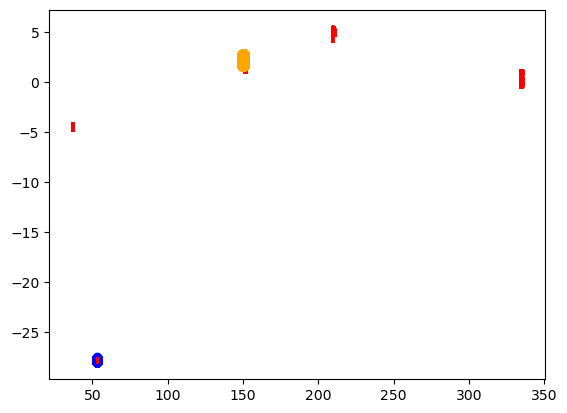

In [49]:
plt.scatter(aces['ra'],aces['dec'],color='blue')
#plt.scatter(vvds['ra'],vvds['dec'],color='red',s=0.5)
plt.scatter(zcosmos['ra'],zcosmos['dec'],color='orange')
#plt.xlim(51,54)
#plt.ylim(-30,-27)

## Selecting ACES AND ZCOSMOS cross-matched

```sql
SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE survey = 'ZCOSMOS' OR survey = 'ACES'
```

In [116]:

query_matched = "SELECT * FROM des_dr2.public_pz_training_set WHERE survey = 'ZCOSMOS' OR survey = 'ACES'"




In [117]:
df_matched = db.fetchall_df(query_matched)

In [118]:


df_matched = df_matched[(df_matched['mag_auto_g_dered']<90) & (df_matched['mag_auto_r_dered']<90) &(df_matched['mag_auto_i_dered']<90) &(df_matched['mag_auto_z_dered']<90) &(df_matched['mag_auto_y_dered']<90)]




In [119]:


df_matched = df_matched[(df_matched['magerr_auto_g']<0.103) & (df_matched['magerr_auto_r']<0.103) &(df_matched['magerr_auto_i']<0.103) &(df_matched['magerr_auto_z']<0.103) &(df_matched['magerr_auto_y']<0.103)]




In [120]:
df_matched.columns=['coadd_object_id','ra','dec','z','err_z','flag_des','survey','flag','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y']

In [121]:
zcosmos_matched = df_matched[df_matched['survey']=='ZCOSMOS']
aces_matched = df_matched[df_matched['survey']=='ACES']

## Main training sample

In [152]:
training_1 = vvds_snx3_matched.sample(int(len(vvds_snx3_matched)/2))
training_2 = sdss_matched.sample(int(len(sdss_matched)/2)) 
training_3 = aces_matched.sample(int(len(aces_matched)/2))
training_4 = two_d_matched.sample(int(len(two_d_matched)/2))
training_5 = ozdes_matched.sample(int(len(ozdes_matched)/2))

In [153]:
print(len(vvds_snx3_matched))
print(len(sdss_matched))
print(len(aces_matched))
print(len(two_d_matched))
print(len(ozdes_matched))

493
659
591
191
561


In [174]:
training = pd.concat([training_2,training_3,training_4,training_5,training_1],axis=0)

In [175]:
training

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
5836,36.136641,-5.481471,36.136641,-5.481471,3.0,21.807480,21.373789,20.680782,20.136896,20.061079,...,0.019053,0.018102,0.020806,0.062883,0.94867,SDSS/BOSS,NaN,NaN,NaN,NaN
31148,37.115675,-3.579292,37.115675,-3.579292,3.0,20.721071,20.123066,19.498674,19.137478,18.629610,...,0.006769,0.006565,0.008656,0.015118,0.51375,SDSS/BOSS,NaN,NaN,NaN,NaN
12278,36.385736,-4.752031,36.385736,-4.752031,3.0,21.396135,20.319326,19.628334,19.285233,19.158482,...,0.012077,0.011305,0.015377,0.031579,0.61463,SDSS/BOSS,NaN,NaN,NaN,NaN
6613,36.020197,-5.287509,36.020197,-5.287509,3.0,21.951574,20.155350,19.405920,19.004028,18.972719,...,0.009720,0.008106,0.011283,0.031354,0.49723,SDSS/BOSS,NaN,NaN,NaN,NaN
4600,35.602271,-4.543265,35.602271,-4.543265,3.0,22.131300,20.367273,19.555399,19.124153,19.030687,...,0.014273,0.011166,0.013959,0.037265,0.55881,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27974,36.955457,-4.624863,36.955457,-4.624863,3.0,22.228693,21.511717,21.021770,20.810612,20.715675,...,0.019556,0.022271,0.035690,0.085164,0.70150,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
29603,37.002334,-4.187342,37.002334,-4.187342,3.0,22.339746,21.268665,20.760635,20.539064,20.565277,...,0.017952,0.020796,0.034383,0.089855,0.20880,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
28039,36.968697,-4.503822,36.968697,-4.503822,3.0,22.280764,21.408216,21.106045,21.001936,20.813368,...,0.019443,0.027201,0.045180,0.099420,0.52630,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
11877,36.278560,-4.342726,36.278560,-4.342726,3.0,20.755342,20.480978,20.354187,20.221491,20.272095,...,0.009078,0.014250,0.023271,0.064645,0.06980,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


## Main testing sample

In [176]:
testing_1 = vvds_snx3_matched.drop(training_1.index)
testing_2 = sdss_matched.drop(training_2.index)
testing_3 = aces_matched.drop(training_3.index)
testing_4 = two_d_matched.drop(training_4.index)
testing_5 = ozdes_matched.drop(training_5.index)

In [177]:
testing = pd.concat([testing_2,testing_3,testing_4,testing_5,vvds_snc3_matched,testing_1],axis=0)

In [178]:
testing

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
23889,37.437240,-5.675342,37.437240,-5.675342,3.0,21.848080,20.027540,19.321104,18.867994,18.668270,...,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS,NaN,NaN,NaN,NaN
24118,37.122262,-5.675978,37.122262,-5.675978,3.0,21.013559,19.355232,18.765299,18.436386,18.270586,...,0.007962,0.008113,0.011619,0.026204,0.33747,SDSS/BOSS,NaN,NaN,NaN,NaN
24076,37.021683,-5.658580,37.021683,-5.658580,3.0,21.452375,19.657553,19.009842,18.633389,18.520651,...,0.007026,0.006160,0.008532,0.025552,0.44146,SDSS/BOSS,NaN,NaN,NaN,NaN
24182,37.065330,-5.593813,37.065330,-5.593813,3.0,20.488775,18.828426,18.263357,17.948309,17.827297,...,0.003822,0.003899,0.005607,0.016953,0.34732,SDSS/BOSS,NaN,NaN,NaN,NaN
24167,37.035687,-5.594757,37.035687,-5.594757,3.0,17.896576,16.699833,16.273424,15.953090,15.821166,...,0.001316,0.001499,0.002168,0.006448,0.19118,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21460,36.624340,-4.124646,36.624340,-4.124646,3.0,22.587524,21.827366,20.926912,20.355436,20.193716,...,0.033168,0.023368,0.031141,0.062711,0.95450,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
21688,36.586662,-4.056139,36.586662,-4.056139,3.0,21.875677,20.444445,19.864115,19.539185,19.403862,...,0.010599,0.009795,0.016800,0.034518,0.54330,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
21697,36.631159,-4.057706,36.631159,-4.057706,3.0,21.928366,20.334253,19.821051,19.555992,19.485413,...,0.015272,0.016737,0.029731,0.064936,0.34360,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
21192,36.477032,-4.092905,36.477032,-4.092905,3.0,22.092154,20.982349,20.419386,20.151390,20.213846,...,0.017082,0.018122,0.027772,0.072631,0.66110,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


## Saving data

In [179]:
del testing['coadd_object_id'], testing['survey'], testing['err_z'], testing['flag'], testing['flag_des'], testing['ra'], testing['dec'], testing['alphawin_j2000'],testing['deltawin_j2000'],testing['extended_class_coadd']
del training['coadd_object_id'], training['survey'], training['err_z'], training['flag'], training['flag_des'], training['ra'], training['dec'], training['alphawin_j2000'],training['deltawin_j2000'],training['extended_class_coadd']


In [181]:
last_column = training.columns[-1]
training = training[[last_column] + [column for column in training.columns if column != last_column]]

last_column2 = testing.columns[-1]
testing = testing[[last_column2] + [column for column in training.columns if column != last_column2]]

In [183]:
g = testing['mag_auto_g']
r = testing['mag_auto_r']
i = testing['mag_auto_i']
z = testing['mag_auto_z']
y = testing['mag_auto_y']
gt = training['mag_auto_g']
rt = training['mag_auto_r']
it = training['mag_auto_i']
zt = training['mag_auto_z']
yt = training['mag_auto_y']

testing['g-r'] = g-r
testing['r-i'] = r-i
testing['i-z'] = i-z
testing['z-y'] = z-y
training['g-r'] = gt-rt
training['r-i'] = rt-it
training['i-z'] = it-zt
training['z-y'] = zt-yt

/tmp/ipykernel_9497/2370129173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['g-r'] = g-r
/tmp/ipykernel_9497/2370129173.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['r-i'] = r-i
/tmp/ipykernel_9497/2370129173.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [185]:
testing.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

In [186]:
testing['eg-r'] = testing['eg']-testing['er']
testing['er-i'] = testing['er']-testing['ei']
testing['ei-z'] = testing['ei']-testing['ez']
testing['ez-y'] = testing['ez']-testing['ey']
training['eg-r'] = training['eg']-training['er']
training['er-i'] = training['er']-training['ei']
training['ei-z'] = training['ei']-training['ez']
training['ez-y'] = training['ez']-training['ey']

/tmp/ipykernel_9497/77383006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['eg-r'] = testing['eg']-testing['er']
/tmp/ipykernel_9497/77383006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['er-i'] = testing['er']-testing['ei']
/tmp/ipykernel_9497/77383006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [189]:
testing.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/testing.sanchez', sep=' ', index = False)
training.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/training.sanchez', sep=' ', index = False)

In [188]:
training

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
5836,0.94867,21.807480,21.373789,20.680782,20.136896,20.061079,0.021597,0.019053,0.018102,0.020806,0.062883,0.433691,0.693007,0.543886,0.075817,0.002544,0.000950,-0.002704,-0.042077
31148,0.51375,20.721071,20.123066,19.498674,19.137478,18.629610,0.008253,0.006769,0.006565,0.008656,0.015118,0.598005,0.624392,0.361197,0.507868,0.001484,0.000203,-0.002091,-0.006462
12278,0.61463,21.396135,20.319326,19.628334,19.285233,19.158482,0.024879,0.012077,0.011305,0.015377,0.031579,1.076809,0.690992,0.343102,0.126751,0.012802,0.000772,-0.004073,-0.016201
6613,0.49723,21.951574,20.155350,19.405920,19.004028,18.972719,0.036949,0.009720,0.008106,0.011283,0.031354,1.796225,0.749430,0.401892,0.031309,0.027229,0.001613,-0.003177,-0.020071
4600,0.55881,22.131300,20.367273,19.555399,19.124153,19.030687,0.052438,0.014273,0.011166,0.013959,0.037265,1.764027,0.811874,0.431246,0.093466,0.038165,0.003107,-0.002793,-0.023306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27974,0.70150,22.228693,21.511717,21.021770,20.810612,20.715675,0.027690,0.019556,0.022271,0.035690,0.085164,0.716976,0.489946,0.211159,0.094936,0.008133,-0.002714,-0.013419,-0.049475
29603,0.20880,22.339746,21.268665,20.760635,20.539064,20.565277,0.039844,0.017952,0.020796,0.034383,0.089855,1.071081,0.508030,0.221571,-0.026213,0.021892,-0.002844,-0.013587,-0.055472
28039,0.52630,22.280764,21.408216,21.106045,21.001936,20.813368,0.033333,0.019443,0.027201,0.045180,0.099420,0.872547,0.302172,0.104109,0.188568,0.013890,-0.007758,-0.017979,-0.054240
11877,0.06980,20.755342,20.480978,20.354187,20.221491,20.272095,0.009310,0.009078,0.014250,0.023271,0.064645,0.274364,0.126791,0.132696,-0.050604,0.000232,-0.005173,-0.009021,-0.041374


## Main sample

In [190]:
main = pd.concat([testing,training],axis=0)

In [194]:
main = main[main['#zs']<1.4]

In [197]:
max(main['#zs'])

1.38478

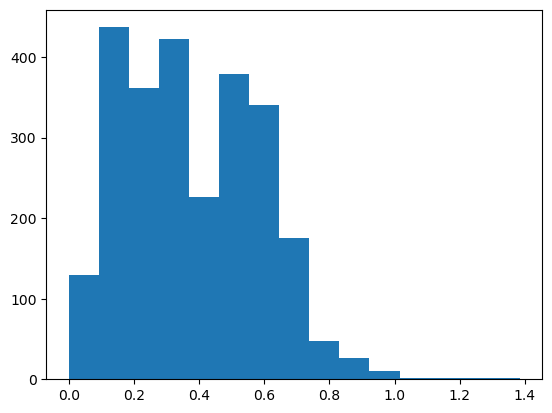

In [196]:
r = plt.hist(main['#zs'], bins = 15)